<a href="https://colab.research.google.com/github/RaziehSh1987/predict-keypoints-of-input-human-image/blob/main/Razieh_thesis_v7_movenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from PIL import Image

In [34]:
path_images='/content/drive/MyDrive/BishopThesis2/CropedImage/person/'
path_model='/content/drive/MyDrive/BishopThesis2/'

interpreter=tf.lite.Interpreter(model_path=path_model+'lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

**load and reshape images**

In [88]:
def load_images(path):
    images_resize = []
    frames=[]
    for filename in os.listdir(path):
        frame = Image.open(path + filename) #original_image(91, 48, 3)
        
        frame=np.array(frame)
        img=frame.copy()
        img=tf.image.resize_with_pad(np.expand_dims(img,axis=0),192,192) #after expand dim (1, 91, 48, 3) #after resize (1, 192, 192, 3)
        input_image=tf.cast(img,dtype=tf.float32) #change type of image based on type of input image for lightening model to fliat32
     
        #  --------
        input_details=interpreter.get_input_details()
        output_details=interpreter.get_output_details()

        interpreter.set_tensor(input_details[0]['index'],input_image) #or np.array(input_images[1300]) #set value for 'index' in 'input details' field
        interpreter.invoke() #call for predict

        # ****************if i want to usemy keypoint--> i must set keypoints by this format age give them to 'keypoints_with_scores'
        keypoints_with_scores=interpreter.get_tensor(output_details[0]['index'])

        draw_connections(frame,keypoints_with_scores,EDGE_COLORS,0.4)
        draw_keypoints(frame,keypoints_with_scores,0.4)

        # ---------


        images_resize.append(input_image)
        frames.append(frame)
    # images1 = np.array(images_resize)
    # return images1,images_resize,frames
    return images_resize,frames,keypoints_with_scores

[[[[0.14466918 0.43610388 0.19322072]
   [0.12433045 0.43637368 0.20841911]
   [0.12502845 0.44103187 0.15536375]
   [0.13341668 0.4481259  0.30433145]
   [0.13467059 0.4687984  0.3361075 ]
   [0.21275738 0.4584775  0.32025948]
   [0.21475086 0.48269138 0.3664873 ]
   [0.29233712 0.50947016 0.08920626]
   [0.3000981  0.5478296  0.16619875]
   [0.36316562 0.45880887 0.05148868]
   [0.36704665 0.62612045 0.25925267]
   [0.43049127 0.4956493  0.54269326]
   [0.43128645 0.50927246 0.64937854]
   [0.658847   0.4805972  0.49464947]
   [0.6451037  0.49539503 0.47244576]
   [0.8203687  0.5506169  0.18725614]
   [0.8181216  0.52078086 0.32412088]]]]


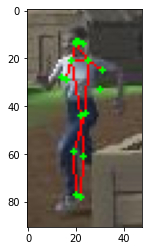

In [89]:
# call load images function and resize them
input_images,frame_original,keypoints= load_images(path_images)

plt.imshow(frame_original[1300])
print(keypoints)

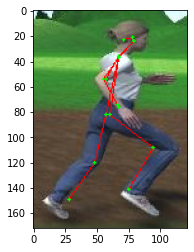

In [87]:
plt.imshow(frame_original[1600])

 **Draw Keypoints**

In [60]:
def draw_keypoints(frame,keypoints,confidence_threshold): 
  x,y,c=frame.shape
  shaped=np.squeeze(np.multiply(keypoints,[x,y,1])) #get all keypoints(x,y,z) of all joints(17 joints) from 1 frame

  for kp in shaped:
     ky,kx,kp_conf=kp #put x,y,z of each joint into ky,kx,kp_conf
     cv2.circle(frame,(int(kx),int(ky)),1,(0,255,0), -1)


**Draw Edges**

 [nose, left eye,
right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist,
right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle])

In [78]:
# dictiory determined which coordinate connected to second cordinate (with color m magentic or ciyan):  (0,1) --> means the first row of coordinates in shaped that is nose is connected to second row which is left eye
EDGE_COLORS = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'c',
    (6, 8): 'm',
    (8, 10): 'c',
    (5, 6): 'm',
    (5, 11): 'c',
    (6, 12): 'm',
    (11, 12): 'c',
    (11, 13): 'm',
    (13, 15): 'c',
    (12, 14): 'm',
    (14, 16): 'c'
}

In [84]:
# function to draw connections
def draw_connections(frame,keypoints,edges,confidence_threshold):
   x,y,c=frame.shape
   shaped=np.squeeze(np.multiply(keypoints,[x,y,1])) #get all keypoints(x,y,z) of all joints(17 joints) from 1 frame

   for edge,color in EDGE_COLORS.items():
     p1,p2=edge
     y1,x1,c1=shaped[p1]#put x,y,z of each joint into y,x,c for first point to draw line
     y2,x2,c2=shaped[p2] #put x,y,z of each joint into y,x,c for second point to draw line
    
     if (c1>confidence_threshold) & (c2>confidence_threshold):
       cv2.line(frame,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0), 1)#draw connection between joints

## **Explain all above code:(it doesnt need to run)**

In [28]:
# ------show information produce datas----------
print(frame_original[1300].shape)
print(np.expand_dims(frame_original[1300],axis=0).shape) #add new dimension in the first (axis=0) place
print(input_images[1300].shape)
print(input_images[1300].dtype)



(91, 48, 3)
(1, 91, 48, 3)
(1, 192, 192, 3)
<dtype: 'float32'>


**setup input and output**

In [37]:
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()

# requiremnet of input and output of  Movement model
print(f'input details of mevenet tensorflow model:\n{interpreter.get_input_details()}')
print(f'output details of mevenet tensorflow model:\n{interpreter.get_output_details()}')


input details of mevenet tensorflow model:
[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output details of mevenet tensorflow model:
[{'name': 'StatefulPartitionedCall:0', 'index': 312, 'shape': array([ 1,  1, 17,  3], dtype=int32), 'shape_signature': array([ 1,  1, 17,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


**Make prediction**

keypoint of 17 joints for one frame= 
[[0.16113764 0.43456656 0.6630484 ]
 [0.14466275 0.45307636 0.5067115 ]
 [0.14594166 0.42310947 0.6695062 ]
 [0.15571778 0.4888762  0.86352277]
 [0.14978682 0.4205833  0.6939702 ]
 [0.23108977 0.5277576  0.83495146]
 [0.23430789 0.390403   0.8507896 ]
 [0.28233355 0.6486557  0.57678246]
 [0.32797623 0.33739123 0.6433003 ]
 [0.36558956 0.6346883  0.33009037]
 [0.31684154 0.29525343 0.63307   ]
 [0.48034853 0.51140326 0.89906806]
 [0.48487478 0.46218276 0.8329629 ]
 [0.6557073  0.39856726 0.71880853]
 [0.67723334 0.48464867 0.65055966]
 [0.85077596 0.42973238 0.7136436 ]
 [0.86153597 0.471911   0.51030654]]
tensor size of output=
(1, 1, 17, 3)
right_eye=
[0.14594166 0.42310947 0.6695062 ]


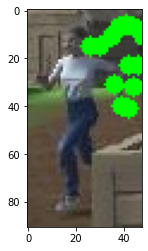

In [57]:
interpreter.set_tensor(input_details[0]['index'],input_images[1300]) #or np.array(input_images[1300]) #set value for 'index' in 'input details' field
interpreter.invoke() #call for predict

# ****************if i want to usemy keypoint--> i must set keypoints by this format age give them to 'keypoints_with_scores'
keypoints_with_scores=interpreter.get_tensor(output_details[0]['index'])

draw_keypoints(frame_original[1300],keypoints_with_scores,0.4)
plt.imshow(frame_original[1300])

print(f'keypoint of 17 joints for one frame= \n{keypoints_with_scores[0][0]}' )#[0]--> access to first array and [?] [0]-->access to  second array #forexample [0][0][2]--> access to cordinate(x,y,z) of right eye

print(f'tensor size of output=\n{keypoints_with_scores.shape}')

right_eye=keypoints_with_scores[0][0][2]
print(f'right_eye=\n{right_eye}')



**Draw keypoints**

In [51]:
print(f'real location of eye in 2D input image =\n{np.array(right_eye[:2]*[91,48]).astype(int)}')
# np.squeeze(keypoints_with_scores[2])  <=is equal to=>  (keypoints_with_scores[0][0][2])
print(np.squeeze(np.multiply(interpreter.get_tensor(interpreter.get_output_details()[0]['index']),[91,48,1])).astype(int))#1st and 2th column multiply [91,48] --- and 3sd column(confidence axis) mulyiply 1

real location of eye in 2D input image =
[13 20]
[[14 20  0]
 [13 21  0]
 [13 20  0]
 [14 23  0]
 [13 20  0]
 [21 25  0]
 [21 18  0]
 [25 31  0]
 [29 16  0]
 [33 30  0]
 [28 14  0]
 [43 24  0]
 [44 22  0]
 [59 19  0]
 [61 23  0]
 [77 20  0]
 [78 22  0]]
